# How Do We Learn the Wave Equation?

In [ ]:
import sys
if True: # On colab
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/omega/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/omega/")
else: # Local
    root = './'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip3 install cmocean
!pip3 install git+https://github.com/rtqichen/torchdiffeq
!pip3 install -U git+https://github.com/afqueiruga/detest

  Cloning https://github.com/rtqichen/torchdiffeq to /private/var/folders/07/0f9_qvmn69x71ny54d22ffyc0000gp/T/pip-req-build-rmc3rzl1
  Running command git clone -q https://github.com/rtqichen/torchdiffeq /private/var/folders/07/0f9_qvmn69x71ny54d22ffyc0000gp/T/pip-req-build-rmc3rzl1
  Created wheel for torchdiffeq: filename=torchdiffeq-0.0.1-cp37-none-any.whl size=25884 sha256=cc3722482eaf405a742f37ccfa9a1cd7134d483bef3c7987472b3c2294cfc9f5
  Stored in directory: /private/var/folders/07/0f9_qvmn69x71ny54d22ffyc0000gp/T/pip-ephem-wheel-cache-nc8lvqkh/wheels/3f/76/69/01867bf3355c3bc8bae7e556b17b44c395b6cda5e76fd8ddc7
Successfully built torchdiffeq
  Cloning https://github.com/afqueiruga/detest to /private/var/folders/07/0f9_qvmn69x71ny54d22ffyc0000gp/T/pip-req-build-7hmvtwn2
  Running command git clone -q https://github.com/afqueiruga/detest /private/var/folders/07/0f9_qvmn69x71ny54d22ffyc0000gp/T/pip-req-build-7hmvtwn2
  Created wheel for detest: filename=detest-0.2-cp37-none-any.whl si

In [ ]:
import numpy as np
from matplotlib import pylab as plt
import matplotlib.animation as animation
import cmocean, seaborn

In [ ]:
#plt.style.use('dark_background')
plt.style.use('default')

In [ ]:
import plotly
import plotly.graph_objects as go

In [ ]:
import utils, plotting, helper, models, ode_helper, \
        analytical_solutions
# Hack for reloading in notebooks without reseting the kernel
import importlib
importlib.reload(utils)
importlib.reload(helper)
importlib.reload(plotting)
importlib.reload(models)
importlib.reload(ode_helper)
importlib.reload(analytical_solutions)

from helper import *
from utils import *
from analytical_solutions import *
from ode_helper import *

In [ ]:
device=get_device()
set_seed()

Connected to a GPU


We can generate any dataset that we want with the analytical solution.

In [ ]:
ts, data = make_wave_dataset(10, 500, t_max=82,
                             params=WAVE_PARAMS[1])
torch_data = data_to_torch(data, device=device)
torch_ts = data_to_torch(ts, device=device)
NT,_,NX = data.shape
dt = ts[1]-ts[0]
print(dt)

[0.19350920659919693, -0.024188650824899606, 0.007167007651822101, -0.0030235813531124464, 0.0015480736527935708, -0.0008958759564777596, 0.0005641667830880341, -0.00037794766913905347, 0.00026544472784526056, -0.00019350920659919448, 0.00014538633102868976, -0.00011198449455971839, 8.807883777842609e-05, -7.052084788600294e-05, 5.733606121457203e-05, -4.724345864238052e-05, 3.9387178220883785e-05, -3.318059098065654e-05, 2.8212451756695488e-05, -2.418865082489838e-05]
0.16432865731462926


We want to learn the true operator, and we'll try multiple strategies to do so:
1. Optimize Omega and take the matrix log
2. Add an elastic net to Omega, and take the matrix log
3. Learn a model in an ODE solver, and hope the model is Lambda
4. Use the mixed ODE-loss, and hypothesize that prevents overfitting.

In [ ]:
class Experiment():
    """
    This is an awkward container class to store experiment
    results in this notebook.
    """
    def __init__(self, learning_rate=None,gamma_L1=0,gamma_L2=0, batch_size=100, ode=False,methods=('euler',),
                 optimizer_key='adam'):
        self.ode = ode
        self.methods=methods
        self.gamma_L1 = gamma_L1
        self.gamma_L2 = gamma_L2
        self.batch_size = batch_size
        self.optimizer_key = optimizer_key
        if ode:
            self.learning_rate = 1.0e-2 if learning_rate is None else learning_rate
            self.model = models.MultiLinearODE((2,NX),(2,NX),bias=False).double().to(device)
        else:
            self.learning_rate = 5.0e-4 if learning_rate is None else learning_rate
            self.model = models.MultiLinear((2,NX),(2,NX),bias=False).double().to(device)
        # This is the awkard state
        self.losses = np.array([])
        self.callback = lambda m,o,l, do_it=False : self._callback(m,o,l, do_it=do_it)
        self.save_schedule = [2.0**-i for i in range(-1,100)]
        self.next_save = self.save_schedule.pop(0)
        self.weight_dump = []
        self.all_metrics = []
        
    def name(self):
        return f"""{"ode_"+"".join([s[0] for s in self.methods]) if self.ode else "mat"}_{self.gamma_L1:1.1e}_{self.gamma_L2:1.1e}_{self.learning_rate:1.1e}_{self.batch_size}"""

    def _callback(self, model, opt_iter, loss, do_it=False):
        if do_it or loss < self.next_save:
            Om = self.model.net.weight.detach().cpu().numpy().copy()
            self.weight_dump.append(Om)
            self.all_metrics.append((opt_iter,loss))
            print("Saving at ",opt_iter, " with loss ",loss)
            self.next_save = self.save_schedule.pop(0)
            
    def train(self,N_iter=10000):
        N_left = N_iter - len(self.losses)
        print(len(self.losses))
        if N_left <= 1: return
        if not self.ode:
            _,losses = learn_rnn(torch_data, self.model,
                N_iter=N_left, batch_size= self.batch_size,
                N_print=100, callback=self.callback,
                learning_rate=self.learning_rate, gamma_L1=self.gamma_L1, gamma_L2=self.gamma_L2,
                device=device)
        else:
            _,losses = train_a_neural_ode_multi_method(torch_data, torch_ts,
                self.model,
                N_iter=N_left, batch_size=self.batch_size,
                learning_rate=self.learning_rate, gamma_L1=self.gamma_L1, gamma_L2=self.gamma_L2,
                methods=self.methods,
                N_print=100,callback=self.callback,
                device=device)
        self.losses = np.append(self.losses,losses)
        
    def post(self):
        if not self.ode:
            self.all_omegas = self.weight_dump.copy()
            self.np_omegas = np.array(self.all_omegas)
            self.UVs = [helper.integrate_matrix(self.np_omegas[i,:,:],
                                    torch_data[0:1,:,:].cpu().numpy(), 25 )
                        for i in range(self.np_omegas.shape[0]) ]
            self.all_lambdas = [ lambda_of_omega(om,dt)
                                for om in self.all_omegas ]
            self.np_lambdas = np.array(self.all_lambdas)
        else:
            self.all_lambdas = self.weight_dump.copy()
            self.np_lambdas = np.array(self.all_lambdas)
            self.all_omegas = [operator_factory(L, dt,method=self.methods[-1]) for L in self.all_lambdas]
            self.np_omegas = np.array(self.all_omegas)

    def make_animation(self,interval=1,transpose=False):
        img = self.np_omegas
        metrics = self.all_metrics
        UVs = self.UVs
        fig, ax = plt.subplots(figsize=(6,3))
        minmax = np.max(np.abs(img)) * 0.65
        tr = lambda x : x.T if transpose else x
        ax_left = plt.subplot(1,2,1)
        ax_left.set_title(f"Iteration #{metrics[0][0]}     Loss = {metrics[0][1]:1.2e}")
        canvas = plt.imshow(tr(img[0,:,:]), interpolation='none',
                            cmap=cmocean.cm.balance, 
                            #interpolation='bicubic', 
                            vmin=-minmax, vmax=minmax)
        plt.axis('off')
        plt.text(-3,5,'$\\frac{du}{dt}$',fontsize=16)
        plt.text(-3,15,'$\\frac{dv}{dt}$',fontsize=16)
        plt.text(5,21,'$u$')
        plt.text(15,21,'$v$')
        ax = plt.subplot(1,2,2)
        ax.set_ylim((-0.5, 0.5))
        ax.set_title("$u(x,t)$")
        xs = np.linspace(0,1,UVs[0].shape[-1])
        line, = ax.plot(xs,UVs[0][0,0,:], lw=2)
        plt.tight_layout()
        def animate(i):
            frame = i//UVs[0].shape[0]
            time = i%UVs[0].shape[0]
            ax_left.set_title(f"Iteration #{metrics[frame][0]}     Loss = {metrics[frame][1]:1.2e}")
            line.set_data(xs,UVs[frame][time,0,:])
            canvas.set_array(tr(img[frame,:,:]))
            return canvas,
        ani = animation.FuncAnimation(fig, animate, frames=img.shape[0]*UVs[0].shape[0],
                                      interval = interval)
        return ani

In [ ]:
stash = {}

In [ ]:
experiments = [
    #dict(),
    # Hyper parameter search
    #dict(learning_rate=1.0,batch_size=25),
    #dict(learning_rate=1.0,batch_size=100),
    #dict(learning_rate=1.0,batch_size=250),
    #dict(learning_rate=1.0e-1,batch_size=25),
    #dict(learning_rate=1.0e-1,batch_size=100),
    #dict(learning_rate=1.0e-1,batch_size=250),
    #dict(learning_rate=1.0e-2,batch_size=25),
    #dict(learning_rate=1.0e-2,batch_size=100),
    dict(learning_rate=1.0e-2,batch_size=250),
    # After tuning those, then tune penalities
    dict(gamma_L1 = 0, gamma_L2 = 1.0e-7,learning_rate=1.0e-2,batch_size=250), # The best
    #dict(gamma_L1 = 0, gamma_L2 = 1.0e-7,learning_rate=1.0e-2,batch_size=250,optimizer_key='sgd'),
    #dict(gamma_L1 = 0, gamma_L2 = 1.0e-5,learning_rate=1.0e-2,batch_size=250),
    #dict(gamma_L1 = 1.0e-5, gamma_L2 = 0.0,learning_rate=1.0e-2,batch_size=250),
    #dict(gamma_L1 = 1.0e-4, gamma_L2 = 1.0e-7,learning_rate=1.0e-2,batch_size=250),

    # Hyper parameter search on ode
    # dict(ode=True,methods=('euler',),learning_rate=1.0,batch_size=25),
    # dict(ode=True,methods=('euler',),learning_rate=1.0,batch_size=100),
    # dict(ode=True,methods=('euler',),learning_rate=1.0,batch_size=250),
    # dict(ode=True,methods=('euler',),learning_rate=1.0e-1,batch_size=25),
    # dict(ode=True,methods=('euler',),learning_rate=1.0e-1,batch_size=100),
    # dict(ode=True,methods=('euler',),learning_rate=1.0e-1,batch_size=250),
    # dict(ode=True,methods=('euler',),learning_rate=1.0e-2,batch_size=25),
    # dict(ode=True,methods=('euler',),learning_rate=1.0e-2,batch_size=100),
    dict(ode=True,methods=('euler',),learning_rate=1.0e-2,batch_size=250), # best? but doesn't fit

    # Hyper parameter search on ode
    # dict(ode=True,methods=('euler','midpoint','rk4'),learning_rate=1.0,batch_size=25),
    # dict(ode=True,methods=('euler','midpoint','rk4'),learning_rate=1.0,batch_size=100),
    # dict(ode=True,methods=('euler','midpoint','rk4'),learning_rate=1.0e-1,batch_size=25),
    # dict(ode=True,methods=('euler','midpoint','rk4'),learning_rate=1.0e-1,batch_size=100),
    #dict(ode=True,methods=('euler','midpoint','rk4'),learning_rate=1.0e-1,batch_size=250),
    # dict(ode=True,methods=('euler','midpoint','rk4'),learning_rate=1.0e-2,batch_size=25),
    # dict(ode=True,methods=('euler','midpoint','rk4'),learning_rate=1.0e-2,batch_size=100),
    #dict(ode=True,methods=('euler','midpoint','rk4'),learning_rate=5.0e-2,batch_size=250),
    #dict(ode=True,methods=('euler','midpoint','rk4'),learning_rate=1.0e-2,batch_size=250),
    #dict(ode=True,methods=('euler','midpoint','rk4'),learning_rate=5.0e-2,batch_size=100),
    #dict(ode=True,methods=('euler','midpoint','rk4'),learning_rate=1.0e-3,batch_size=250),
    #dict(ode=True,methods=('euler','midpoint','rk4'),learning_rate=1.0e-4,batch_size=250),
    # Change the methods we use
    #dict(ode=True,methods=('midpoint','rk4'),learning_rate=1.0e-1,batch_size=250),
    #dict(ode=True,methods=('midpoint','rk4'),learning_rate=5.0e-2,batch_size=250),
    # dict(ode=True,methods=('midpoint','rk4'),learning_rate=1.0e-2,batch_size=250),
    # dict(ode=True,methods=('midpoint','rk4'),learning_rate=1.0e-1,batch_size=250),
    #dict(ode=True,methods=('midpoint','rk4'),learning_rate=1.0,batch_size=250),
    #dict(ode=True,methods=('midpoint','rk4'),learning_rate=1.0e-1,batch_size=250),
    dict(ode=True,methods=('midpoint','rk4'),learning_rate=1.0e-2,batch_size=250),
    #dict(ode=True,methods=('midpoint','rk4'),learning_rate=1.0e-2,batch_size=250),
    #dict(ode=True,methods=('midpoint','rk4'),learning_rate=5.0e-2,batch_size=100),
    #dict(ode=True,methods=('midpoint','rk4'),learning_rate=1.0e-3,batch_size=250),
    #dict(ode=True,methods=('midpoint','rk4'),learning_rate=1.0e-4,batch_size=250),
    #dict(ode=True,methods=('euler',),),
    #dict(ode=True,methods=('midpoint',)),
    #dict(ode=True,methods=('rk4',)),
    #dict(ode=True,methods=('midpoint','rk4'),learning_rate=1.0e-2,batch_size=250, gamma_L2=1.0e-7),
    #dict(ode=True,methods=('midpoint','rk4'),learning_rate=1.0e-2,batch_size=250, gamma_L2=1.0e-9),
    #dict(ode=True,methods=('midpoint','rk4'),learning_rate=1.0e-2,batch_size=250, gamma_L2=1.0e-10),
    #dict(ode=True,methods=('midpoint','rk4'),learning_rate=1.0e-2,batch_size=250, gamma_L2=1.0e-11),
    #dict(ode=True,methods=('midpoint','rk4'),learning_rate=1.0e-1,batch_size=250, gamma_L2=1.0e-7),

    #dict(ode=True,
    #             methods=('euler','midpoint','rk4')),
    # dict(ode=True,
    #             methods=('euler','midpoint','rk4'),
    #             gamma_L1 = 1.0e-5, gamma_L2 = 1.0e-7),
    # dict(ode=True,
    #             methods=('euler','midpoint','rk4'),
    #             gamma_L1 = 0, gamma_L2 = 1.0e-7),
    # dict(ode=True,
    #             methods=('euler','midpoint','rk4'),
    #             gamma_L1 = 1.0e-6, gamma_L2 = 0),
    # dict(ode=True,methods=('midpoint','rk4')),
]

In [ ]:
# for exp in stash.values():
#     if exp.ode==True:
#         exp.learning_rate = 5.0e-1
#     else:
#         exp.learning_rate = 5.0e-2
#     exp.batch_size=250

In [ ]:
N_iter = 100000
for exp in experiments:
    try:
        exp_obj = stash[tuple(exp.items())]
    except:
        exp_obj = Experiment(**exp)
        stash[tuple(exp.items())] = exp_obj
    exp_obj.train(N_iter=N_iter)

50000
Saving at  49999  with loss  0.00012914614760261927
50000
Saving at  49999  with loss  0.00013732894408553887
50000
Saving at  49999  with loss  6.193168804030338e-05
50000
Saving at  49999  with loss  8.84929624426419e-05


In [ ]:
data = []
#for config in stash:
for config in experiments:
    exp = stash[tuple(config.items())]
    try:
        data.append(go.Scatter(y=exp.losses[::20],name=exp.name()))
    except:
        print("Skipping ",config)
go.Figure(data=data,layout=dict(yaxis_type="log") )

/content/drive/My Drive/Colab Notebooks/omega/utils.py:16: ComplexWarning:

Casting complex values to real discards the imaginary part

/content/drive/My Drive/Colab Notebooks/omega/utils.py:10: RuntimeWarning:

divide by zero encountered in log



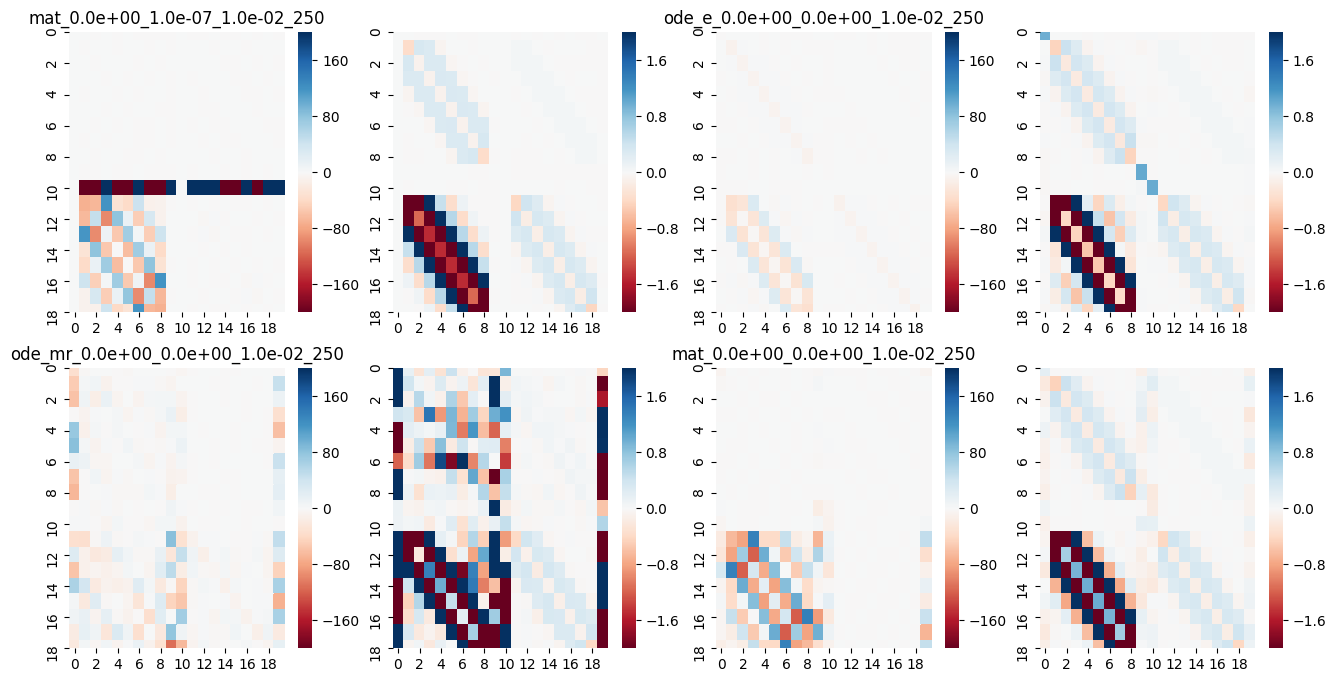

In [ ]:
cols = 2
sp_y,sp_x = int(len(stash)/cols+0.5), 2*cols
plt.figure(figsize=(4*sp_x,4*sp_y))
for i,exp in enumerate(stash.values()):
    try:
        exp.post()
        plt.subplot(sp_y,sp_x,2*i+1)
        plt.title(exp.name())
        seaborn.heatmap(exp.all_lambdas[-1], cmap='RdBu', center=0,vmin=-200,vmax=200)
        plt.subplot(sp_y,sp_x,2*i+2)
        seaborn.heatmap(exp.all_omegas[-1], cmap='RdBu', center=0, vmin=-2,vmax=2)
    except Exception as e:
        print(e)
        print("Skipping ",exp.name())
plt.show()

In [ ]:
Dx = 1.0/9.0 # confident it's 1/9
three_pt = np.array([1,-2,1])/Dx**2
five_pt = np.array([-1,16,-30,16,-1])/(12*Dx**2)
seven_pt = np.array([1/90,-3/20,3/2,-49/18,3/2,-3/20,1/90])/Dx**2
print(three_pt)
print(five_pt)

[  81. -162.   81.]
[  -6.75  108.   -202.5   108.     -6.75]


-0.6423202842373144
-3.3334613004977864
-12.195748033700472
20.309469318313333


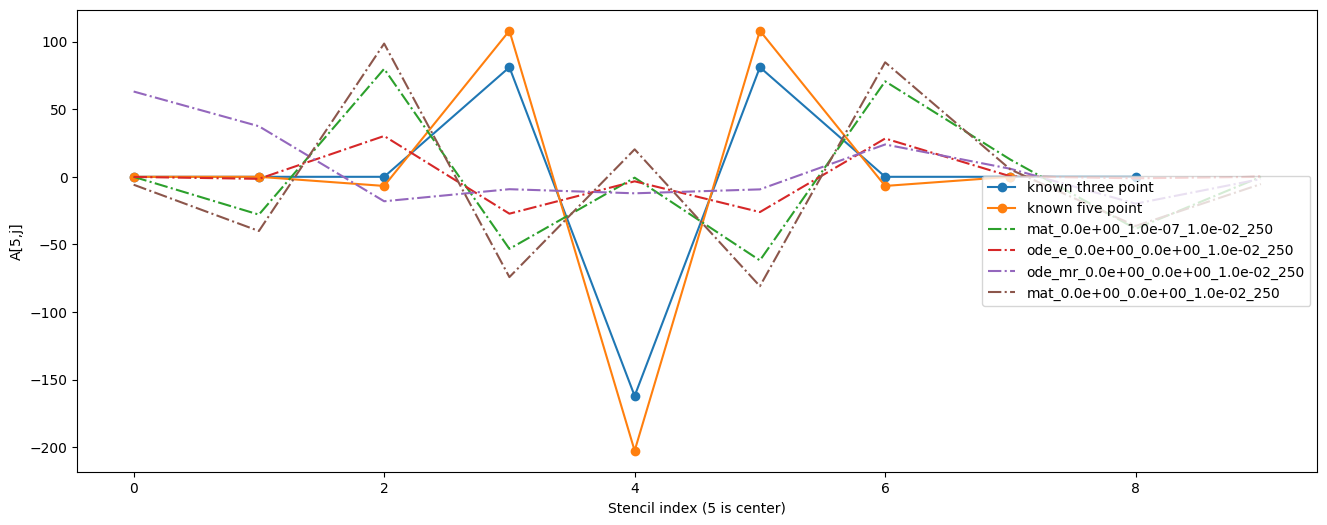

In [ ]:
np.set_printoptions(precision=3)
plt.figure(figsize=plotting.FIG_SIZE_FULL)
off = 4
plt.plot(np.r_[np.zeros(off-1), three_pt,np.zeros(10-off-3)], 'o-', label='known three point')
plt.plot(np.r_[np.zeros(off-2), five_pt, np.zeros(10-off-5)], 'o-', label='known five point')
for exp in stash.values():
    if not hasattr(exp,'all_lambdas'):
        exp.post()
    row = exp.all_lambdas[-1][10+off,0:10]
    print(row[off])
    plt.plot(row,'-.',label=exp.name())
plt.legend(loc='right')
plt.xlabel('Stencil index (5 is center)')
plt.ylabel('A[5,j]')
plt.show()

In [ ]:
off = 4
data = [
        go.Scatter(y=exp.all_lambdas[-1][10+off,0:10],name=exp.name(),line=dict(dash='dash'))
        for exp in stash.values()
] + [
     go.Scatter(y=np.r_[np.zeros(off-1),three_pt,np.zeros(10-off-3)],name='known three point'),
     go.Scatter(y=np.r_[np.zeros(off-2),five_pt,np.zeros(10-off-5)],name='known five point'),
     go.Scatter(y=np.r_[np.zeros(off-3),seven_pt,],name='known sevent point'),
]
go.Figure(data,layout=dict(margin=dict(t=0,b=0,l=0,r=0)))

In [ ]:
eoff = 4
data = [
        go.Scatter(y=exp.all_omegas[-1][10+off,:],name=exp.name(),line=dict(dash='dash'))
        for exp in stash.values()
]
go.Figure(data,layout=dict(margin=dict(t=0,b=0,l=0,r=0)))

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



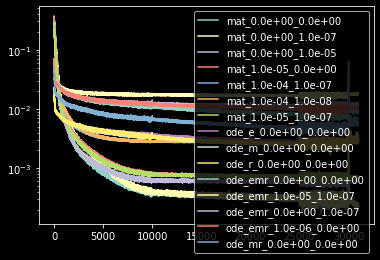

In [ ]:
for exp in stash.values():
    try:
        plt.semilogy(exp.losses,'-',label=exp.name())
    except:
        print("Skipping ",n)
plt.legend()

## Hyperparamter test:

It turns out that the ODE methods need learning rates with a different tuning.

In [ ]:
LR_HYPER = { k:Experiment(ode=True,learning_rate=k) for k in [0.1,1.0e-2,1.0e-3,5.0e-4,1.0e-4,5.0e-5]}
N_iter=1000
for k,exp in LR_HYPER.items():
    exp.train(N_iter=N_iter)

0
Saving at  99  with loss  0.00727930242639966
Saving at  199  with loss  0.005805940871530241
Saving at  299  with loss  0.0052550329015693875
Saving at  399  with loss  0.005256647543202013
Saving at  499  with loss  0.00486704718266773
Saving at  599  with loss  0.004596436192558001
Saving at  699  with loss  0.004469632127155332
Saving at  799  with loss  0.00437673684349335
Saving at  899  with loss  0.004533807968909094
Saving at  999  with loss  0.004433495923945411
0
Saving at  99  with loss  0.010927190519990233
Saving at  199  with loss  0.008922665912668597
Saving at  299  with loss  0.009168351943503737
Saving at  399  with loss  0.008313489885006863
Saving at  499  with loss  0.0078999356252841
Saving at  599  with loss  0.007673140748689698
Saving at  699  with loss  0.00714829625342742
Saving at  799  with loss  0.007063807870145809
Saving at  899  with loss  0.006704557244741682
Saving at  999  with loss  0.0063775015806655285
0
Saving at  99  with loss  0.018142775105

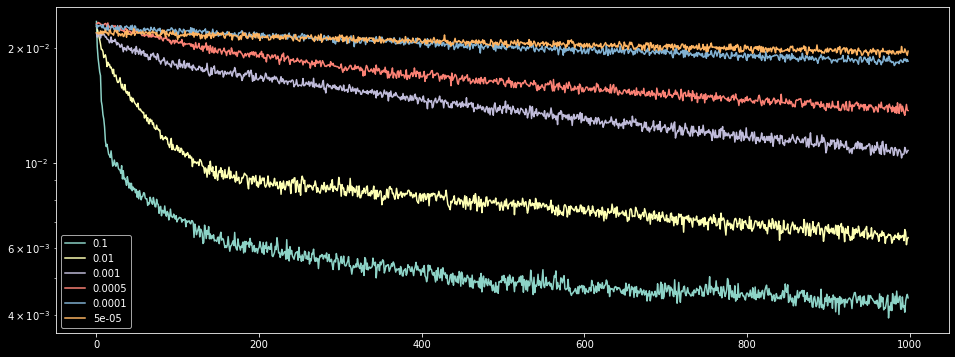

In [ ]:
plt.figure(figsize=plotting.FIG_SIZE_FULL)
for n,exp in LR_HYPER.items():
    try:
        plt.semilogy(exp.losses,'-',label=n)
    except:
        print("Skipping ",n)
plt.legend()
plt.show()

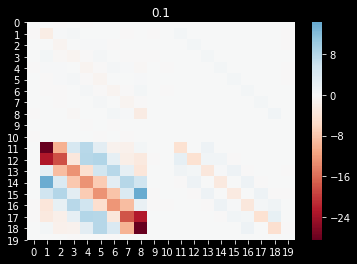

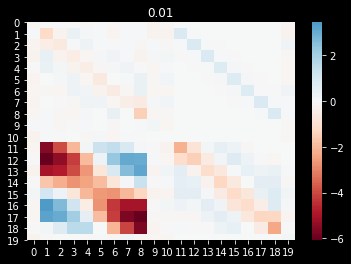

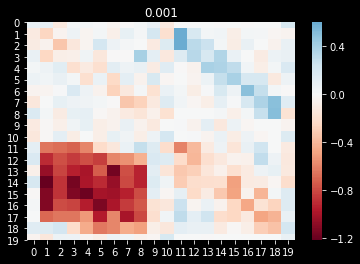

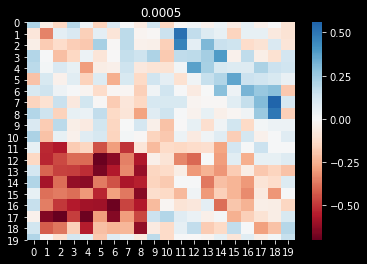

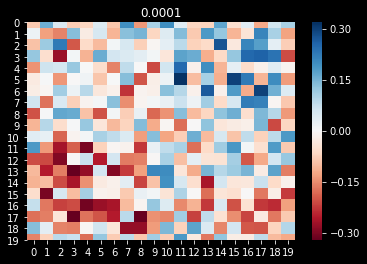

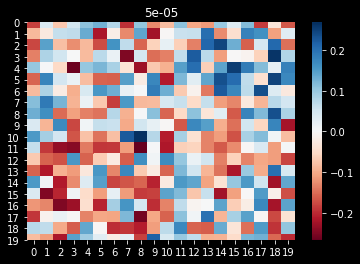

In [ ]:
for n,exp in LR_HYPER.items():
    try:
        exp.post()
        plt.figure()
        plt.title(n)
        seaborn.heatmap(exp.all_lambdas[-1], cmap='RdBu', center=0)
    except:
        print("Skipping ",n)